# Better Tree Notebook

- status: finished
- inclusion of Hosts and other Stuff
- better runtime
- better use of cluster dataframe
- rewrite vectorzier and clusterer iteratively, so the used data format matches the clusterer pipeline

In [1]:
import collections as co
import pandas as pd
import numpy as np
import seaborn as sns
import re
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, RectFace, SequenceFace
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
import math
from matplotlib import colors
from Bio import SeqIO
from natsort import natsorted

In [63]:
def roundup(x):
    return(int(math.ceil(int(x) / 10.0)) * 10)

In [64]:
def rounddown(x):
    return(int(math.floor(int(x) / 10.0)) * 10)

In [65]:
def getTimespan(year):
    
    try:
        down = rounddown(int(year))
        up = roundup(int(year))
        if down == up:
            timespan = f'{down}-{up+10}'
        else:
            timespan = f'{down}-{up}'
    except:
        timespan = 'NA'#np.nan
    
    return(timespan)

In [66]:
def getHostselection(host, hostdict):
    
    hostsel = ''
    for key in hostdict.keys():
        if re.match('(?:% s)' % '|'.join(hostdict[key]), host, re.IGNORECASE):
            hostsel = key
            break
    if not hostsel:
        hostsel = 'NA'
        #hostsel = host
    
    return(hostsel)

In [67]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [68]:
def getVector(frame, components, col):

    duplicate = components.copy()
    duplicate.update(frame[col].value_counts().to_dict())
    
    vector = pd.DataFrame([duplicate.values()])
    duplicate.clear()
    
    return(vector)

In [105]:
#input has to be checked befor finishing the tree class, so implementation of a checkup befor starting is necessary
#rewriting the code as class instead of 5 functions also necessary
#infile, outfile and so on and so forth
def getTree(framelink, frameclust, framemeta, feature = ['H', 'hostsel', 'hostsel'], rownumber = 2, segment = 4, prune = True, treshold = [0.5, 0.5, 0.5]):
    
    #-------input format check here--------
    
    columns = list(set(feature))
    columns.append('cluster')

    treequery = frameclust.loc[segment].join(framemeta)[columns]
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    treelink = framelink.loc[segment].drop(columns=['parent']).to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    treedict = treequery.to_dict()

    listfeature = dict.fromkeys(feature)
    listcluster = dict.fromkeys(feature)
    treecomponents = dict.fromkeys(feature)
    featurevectors = dict.fromkeys(feature)
    featurel1vectors = dict.fromkeys(feature)
    framefeature = dict.fromkeys(feature)

    for feat in feature:

        listfeature[feat] = list(set(treedict[feat].values()))
        treecomponents[feat] = dict.fromkeys(listfeature[feat], 0)
        featurevectors[feat] = treequery.groupby(by=['cluster']).apply(lambda x: getVector(x, treecomponents[feat], feat))
        featurevectors[feat].reset_index(level = 1, drop = True, inplace=True)

        listcluster[feat] = featurevectors[feat].index.tolist()
        featurel1vectors[feat] = normalize(featurevectors[feat].to_numpy(), norm='l1')
        framefeature[feat] = pd.DataFrame(featurel1vectors[feat], index = listcluster[feat], columns = listfeature[feat])

    tree = Tree(treenewick)
    
    listcolor = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00',
                 '#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF',
                 '#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5', 
                 '#99A893','#EED5D2','#3F00FF','#DABF86']
    
    for a,b in zip(feature,treshold):
        if b != 0.0:
            listfeature[a].append('mixed')
        
    mainfeature = natsorted(listfeature[feature[0]])
    maincluster = listcluster[feature[0]]
    if -1 in maincluster:
        maincluster.remove(-1)
    
    dictcolor = dict(zip(mainfeature, listcolor[0:len(mainfeature)]))
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    #maybe clean up here a little bit (runtime of the clusterlist?)
    if prune == True:
        
        for leaf in tree.iter_leaves():
            leaf.feature = [treedict[feat].get(leaf.name, "none") for feat in feature]
            leaf.cluster = treedict['cluster'].get(leaf.name, "none")
        
        pruneclust = []
        for cluster in maincluster:
            listmember = tree.search_nodes(cluster=cluster)
            nodecluster = tree.get_common_ancestor(listmember)
            nodecluster.name = f'cluster {cluster}'
            nodecluster.size = len(listmember)
            nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
            nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") #oder alles aligned, geht auch

            position = dict.fromkeys(feature, 0)
            for i, (feat,tresh) in enumerate(zip(feature, treshold),1):

                frame = framefeature[feat].loc[cluster].sort_values(axis=0, ascending=False)

                if tresh != 0.0:
                    # wenn schon einmal hostsel, dann 2. meister host blabla
                    # wenn .max() == 1.0 dann KEIN 2. host; also 2.host = 'none'
                    clusterfeature = frame.index[position[feat]] if frame.iloc[position[feat]] >= tresh else ('none' if frame.iloc[position[feat]] == 0.0 else 'mixed')
                else:
                    clusterfeature = frame.index[position[feat]]

                if i == 1:
                    nodecluster.img_style['bgcolor'] = dictcolor[clusterfeature]
                elif i % 2 != 0:
                    nodecluster.add_face(TextFace('|' + clusterfeature + '|', fsize=10), i, position="aligned")
                else:
                    nodecluster.add_face(TextFace(clusterfeature, fsize=10), i, position="aligned")

                position[feat] =+ 1

            position.update((k,0) for k in position.keys())
            pruneclust.append(nodecluster.name)
            
        tree.prune(pruneclust)
    
    else:
        
        for leaf in tree.iter_leaves():
            leaf.feature = [treedict[feat].get(leaf.name, "none") for feat in feature]
            leaf.cluster = treedict['cluster'].get(leaf.name, "none")
        
            leaf.add_face(AttrFace("name", fsize=10), 0, position="aligned")
            leaf.img_style['bgcolor'] = dictcolor[leaf.feature[0]]
            
        for cluster in maincluster:
            listmember = tree.search_nodes(cluster=cluster)
            nodecluster = tree.get_common_ancestor(listmember)
            nodecluster.name = f'cluster {cluster}'
            nodecluster.size = len(listmember)
            nodecluster.img_style['bgcolor'] = dictcolor[leaf.feature[0]]
        
        if type(prune) == list: 
            tree.prune(prune)
    
    treestyle =  TreeStyle()
    treestyle.show_leaf_name = False
    treestyle.draw_guiding_lines = True
    treestyle.guiding_lines_color = 'black'
    treestyle.mode = "c"
    treestyle.allow_face_overlap = False

    column = 0
    for j, feature in enumerate(mainfeature, 1): 
        legendcolor = RectFace(width = 20, height = 20, fgcolor = "#000000", bgcolor = dictcolor[feature], label = None)
        treestyle.legend.add_face(legendcolor, column = column)
        legendtext = TextFace(feature)
        legendtext.margin_right = 5
        legendtext.margin_left = 1
        treestyle.legend.add_face(legendtext, column = column + 1)

        if j%rownumber == 0:
            column = column + 2

    treestyle.legend_position = 1
        
    return(tree, treestyle)

In [70]:
def fillGaps(frame):
    
    arrayH = frame['H'].unique()
    arrayH = arrayH[arrayH != '']
    if len(arrayH) == 1:
        frame['H'].replace('', arrayH[0], inplace = True)
        frame['H'].fillna(arrayH[0], inplace = True)
    else:
        frame['H'].replace('', 'NA', inplace = True)
        frame['H'].fillna('NA', inplace = True)

    arrayN = frame['N'].unique()
    arrayN = arrayN[arrayN != '']
    if len(arrayN) == 1:
        frame['N'].replace('', arrayN[0], inplace = True)
        frame['N'].fillna(arrayN[0], inplace = True)
    else:
        frame['N'].replace('', 'NA', inplace = True)
        frame['N'].fillna('NA', inplace = True)
        
    return(frame)

In [71]:
link = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
framelink = link.set_index(keys = 'segment')
frameclust = cluster.reset_index().set_index(keys = ['segment', 'accession'])
frameclust[['H', 'N']] = frameclust.groupby(by = ['segment', 'cluster'])[['H', 'N']].apply(lambda x : fillGaps(x))

In [72]:
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
framemeta = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
framemeta.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'season', 'country', 'america']
framemeta[['month', 'day', 'year']] = framemeta['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
framemeta['year'] = framemeta['year'].apply(lambda x: x if not x.startswith('00') else '20' + x[2:])
framemeta.set_index(keys = 'accession', inplace = True)

In [73]:
hostdict =	{
    "human": [".*human.*"],
    "duck": [".*duck.*", ".*scaup.*", ".*pochard.*", ".*mallard.*", ".*bufflehead.*", ".*gadwall.*", ".*teal.*", ".*pintail.*", ".*shoveler.*", ".*wigeon.*", ".*pintail.*", ".*godwall.*", ".*goldeneye.*"],
    "bird": [".*murre.*", ".*crane.*", ".*hawk.*", ".*dove.*", ".*parrot.*", ".*dunlin.*", ".*owl.*", ".*shearwater.*", ".*bird.*", ".*grebe.*", ".*pheasant.*", ".*stint.*", ".*sparrow.*", ".*crow.*", ".*sandpiper.*", ".*falcon.*", ".*ostrich.*", ".*stork.*", ".*pigeon.*", ".*turkey.*", ".*sanderling.*", ".*knot.*", ".*quail.*", ".*waterfowl.*", ".*turnstone.*", ".*bird.*", ".*fowl.*", ".*avian.*"],
    "gull": [".*gull.*"],
    "chicken": [".*chicken.*"],
    "cat": [".*cat.*", ".*tiger.*"],
    "bat": [".*bat.*"],
    "swan": [".*swan.*"],
    "swine": [".*swine.*"],
    "equine": [".*equine.*"],
    "dog": [".*dog.*"],
    "goose": [".*goose.*"],
    "horse": [".*horse.*"],
    "environment": [".*environment.*"],
    "NA": [".*unknown.*"],
    "ferret": [".*mink.*", ".*ferret.*", ".*weasel.*"]
}

In [74]:
framemeta['timespan'] = framemeta['year'].apply(lambda x : getTimespan(x))
framemeta['hostsel'] = framemeta['host'].apply(lambda x : getHostselection(x, hostdict))

In [93]:
tree, ts = getTree(framelink, frameclust, framemeta, feature = ['H', 'hostsel', 'hostsel', 'timespan'] , rownumber = 2, segment = 4, prune = True, treshold = [1.0, 0.65, 0.15, 0.65])
_ = tree.render(file_name = 'H_100_Host1_65_Host2_25.pdf', tree_style = ts, w=1200)

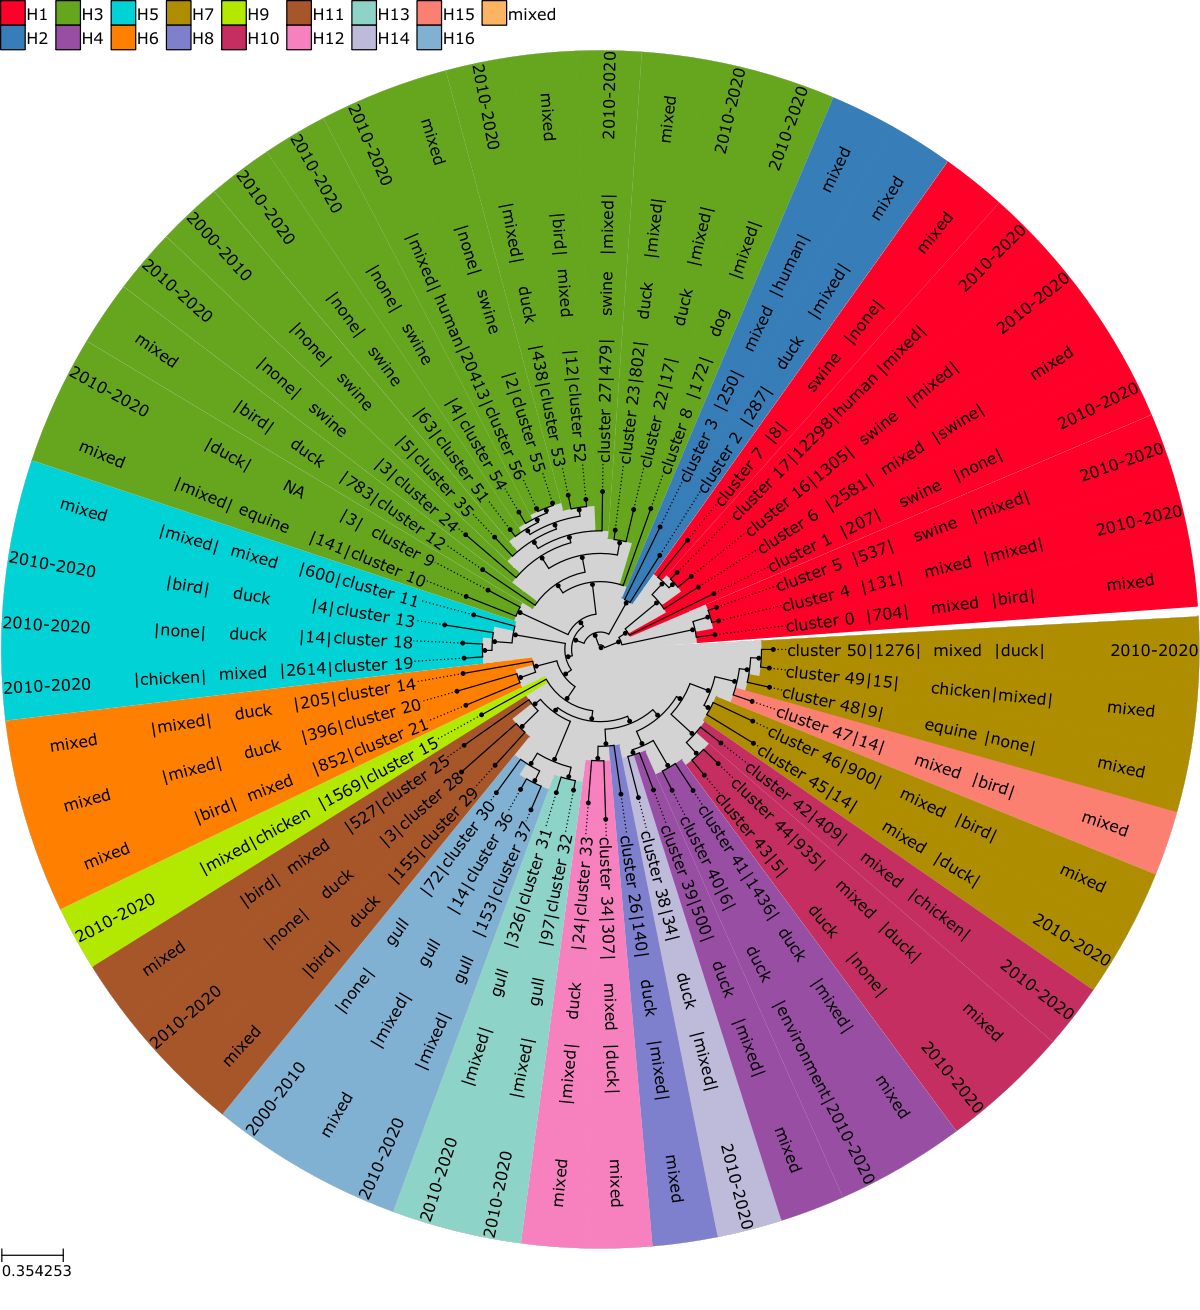

In [94]:
tree.render(file_name = '%%inline', tree_style = ts, w=1200)

In [98]:
x = frameclust.loc[4].join(framemeta).query('cluster == 53').index.tolist()

In [107]:
tree, ts = getTree(framelink, frameclust, framemeta, feature = ['H', 'hostsel', 'hostsel', 'timespan'] , rownumber = 2, segment = 4, prune = x, treshold = [1.0, 0.65, 0.15, 0.65])

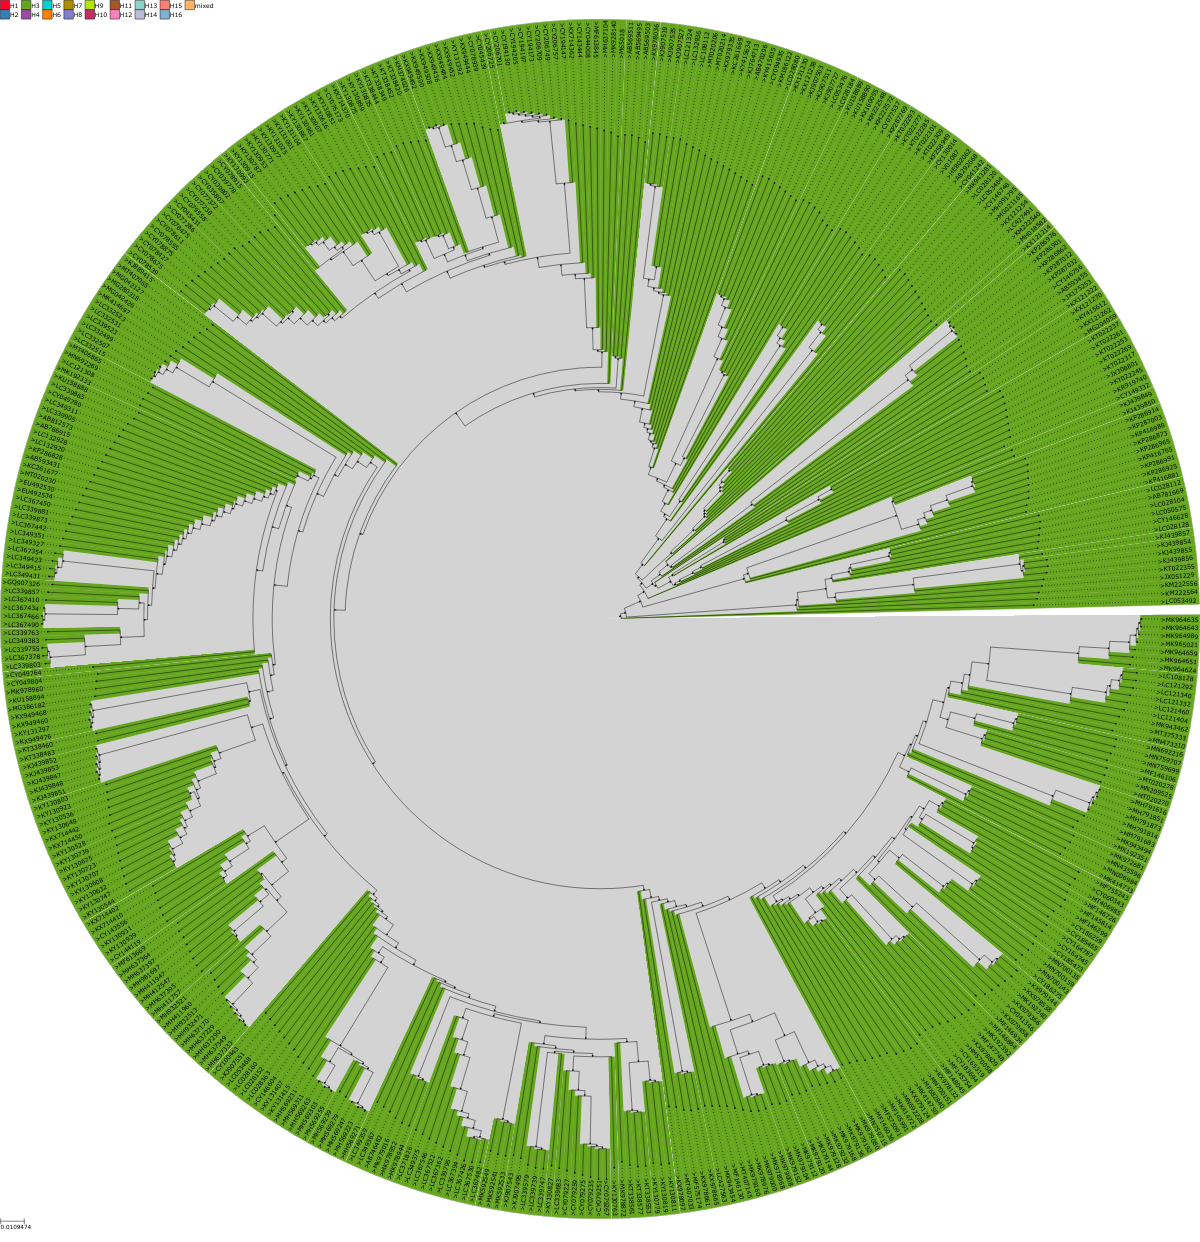

In [108]:
tree.render(file_name = '%%inline', tree_style = ts, w=1200)

In [76]:
def getSubset(accessionlist, inputhandle, outputhandle = ''):
    
    inputhandle  = open("A.fasta", "r")
    
    if outputhandle:
        for rec in SeqIO.parse(inputhandle,"fasta"):
            if '>'+rec.id.split('|')[0] in accessionlist:
                outputhandle.write(">%s\n%s\n" % (
                   rec.id,
                   rec.seq))

        outputhandle.close()
    
    else:
        for rec in SeqIO.parse(inputhandle,"fasta"):
            if '>'+rec.id.split('|')[0] in accessionlist:
                print(">%s\n%s\n" % (
                   rec.id,
                   rec.seq))
    
    inputhandle.close()

In [5]:
x = SeqIO.parse("A.fasta","fasta")

In [62]:
next(x).id

'CY073730|A/Aalborg/INS283/2009|3|PA|A|H1N1|12/07/2009|Human|Pass|09_10|Denmark|NA'